In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as spatial
from Helpers import helpers, twod_laplace

In [14]:
plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")

In [15]:
plain_df = plain_df.drop(columns=['class'])
plain_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks
0,120.0,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0
1,132.0,4.0,0.0,4.0,2.0,130.0,68.0,198.0,6.0
2,133.0,2.0,0.0,5.0,2.0,130.0,68.0,198.0,5.0
3,134.0,2.0,0.0,6.0,2.0,117.0,53.0,170.0,11.0
4,132.0,4.0,0.0,5.0,0.0,117.0,53.0,170.0,9.0


In [16]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
perturbed_df_2d = perturbed_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [17]:
import random
from sklearn.preprocessing import MinMaxScaler

def get_Z_outside_domain_X(plain_df, perturbed_df):
    """tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask"""
    outside_domain_mask = np.logical_or.reduce([np.logical_or(perturbed_df[:, dim] <= plain_df[:, dim].min(), perturbed_df[:, dim] >= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])
    return outside_domain_mask

def get_radius_and_perturbation(plain_df, epsilon):
    data = {'r': [], 'x': [], 'y': []}
    # loop through each record
    for row in plain_df.values:
        p = random.random()
        theta = np.random.rand()*np.pi*2
        r = twod_laplace.inverseCumulativeGamma(epsilon, p) # draw radius distance
        private_point = twod_laplace.addVectorToPoint(row, r, theta)
        data['r'].append(r)
        data['x'].append(private_point[0])
        data['y'].append(private_point[1])

    return pd.DataFrame(data)

def transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

def inverse_transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.inverse_transform(dataframe), columns=dataframe.columns)



In [18]:
tree = spatial.KDTree(plain_df_2d)
query_data = tree.query_ball_point([132.0,4.0], r=0.3)
plain_df_2d.iloc[query_data]

,baseline value,histogram_min


In [19]:
min_max_scaler = MinMaxScaler(feature_range=[-1,1])
min_max_scaler_perturbed = MinMaxScaler(feature_range=[-1,1])


In [20]:
perturbed_data_with_r = get_radius_and_perturbation(plain_df_2d, 0.5)
perturbed_data_with_r.head()

,r,x,y
0,3.712604,120.327519,65.698129
1,6.578180,126.868592,63.884043
2,1.530812,134.426791,67.445334
3,3.453012,137.024349,51.333685
4,0.532388,131.548437,52.717992


In [21]:
outside_domain_mask = get_Z_outside_domain_X(plain_df_2d.values, perturbed_data_with_r.drop(columns=['r']).values)


In [22]:
perturbed_data_with_r_outside_domain = perturbed_data_with_r.drop(columns=['r'])[outside_domain_mask]
perturbed_data_with_r_outside_domain = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain], axis=1)

In [23]:
perturbed_data_with_r_outside_domain.head()

,r,x,y
6,2.091802,136.091108,49.946136
22,6.919048,124.526054,48.016278
28,2.366338,133.420859,48.107722
30,3.034034,134.999780,49.545378
34,4.621442,118.363433,48.678036


In [24]:
# perturbed_data_with_r_outside_domain_scaled = pd.DataFrame(min_max_scaler.fit_transform(perturbed_data_with_r_outside_domain), columns=perturbed_data_with_r_outside_domain.columns)


In [25]:
random_point = perturbed_data_with_r_outside_domain.iloc[2]
plain_tree = spatial.KDTree(plain_df_2d)
perturbed_query_data = plain_tree.query_ball_point([random_point['x'], random_point['y']], r=random_point['r'])

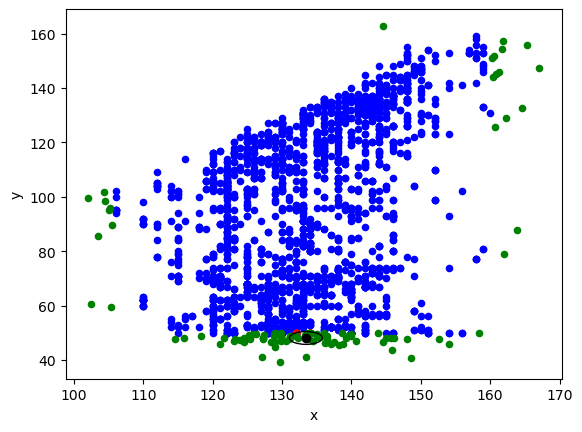

In [26]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
plain_df_2d.iloc[perturbed_query_data].plot(kind='scatter', x='baseline value', y='histogram_min', color='red', ax=ax)
perturbed_data_with_r_outside_domain.plot(kind='scatter', x='x', y='y', color='green', ax=ax)
ax.add_patch(plt.Circle((random_point['x'], random_point['y']), random_point['r'], color='black', fill=False))
ax.scatter(random_point['x'], random_point['y'], color='black')

In [27]:
perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10, columns=['x', 'y'], include_indicator=True)
# perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['baseline value', 'histogram_min'])
perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped = perturbed_data_with_r_remapped[perturbed_data_with_r_remapped['is_remapped']]
print(perturbed_data_with_r_remapped.shape, perturbed_data_with_r_outside_domain_remapped.shape)

(2126, 4) (222, 4)


In [28]:
"""perturbed_data_with_r_outside_domain_remapped = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=True)
perturbed_data_with_r_outside_domain_remapped.head()"""
perturbed_data_with_r_remapped.head()


,r,x,y,is_remapped
0,3.712604,120.327519,65.698129,False
1,6.578180,126.868592,63.884043,False
2,1.530812,134.426791,67.445334,False
3,3.453012,137.024349,51.333685,False
4,0.532388,131.548437,52.717992,False


<AxesSubplot:xlabel='x', ylabel='y'>

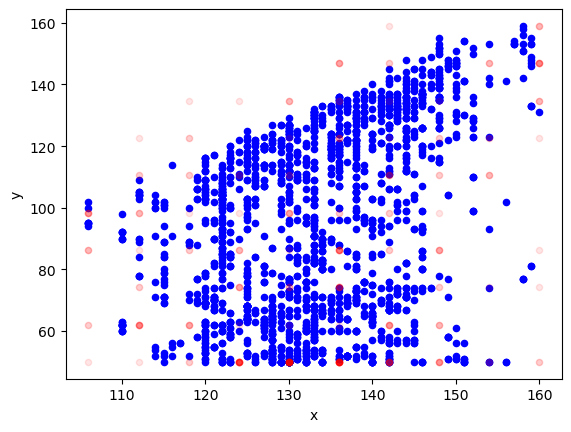

In [29]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)


In [30]:
import math
import scipy.spatial as spatial


def calculate_distance(point1, point2):
    #return spatial.distance.euclidean(point1, point2)  # Euclidean distance as an example
    return np.linalg.norm(point1 - point2)

def remap_point(x, z_popularity, fake_data, real_data, radius, epsilon, plain_tree, w_x):
    w_x = len(w_x) + len(z_popularity)
    #w_q_sum = sum([len(calculate_popularity(q, real_data, radius)) for q in Q_r(x, z, real_data, radius)])
    q = Q_r(x, real_data, radius, plain_tree)
    w_q_sum = len(q)

    # q_calc = (w_q_sum * math.exp(-epsilon * calculate_distance(q, z)))
    #print(w_q_sum)
    distance_xz = calculate_distance(x, fake_data)
    #epsilon_offset = 1e-6  # Small offset to avoid division by zero or infinite results
    
    remapped_value = (w_x * math.exp(-epsilon * distance_xz)) / w_q_sum if w_q_sum > 0 else 0
    
    return remapped_value

def Q_r(x, points, radius, kd_tree=None):
    kdtree = spatial.KDTree(points) if kd_tree is None else kd_tree
    indices = kdtree.query_ball_point((x), radius)
    return [points[i] for i in indices]

def find_new_r_for_perturbed_datas_outside_domain(perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_with_Q = perturbed_data.copy()
    for index, point in perturbed_data_with_Q.iterrows():
        x = plain_df.iloc[index]
        new_r = { 'x_new': [], 'y_new': []}
        for column in ['x', 'y']:
            #print(point[column], x[column])
            polularity_x = Q_r([x[column]], [point[column]], plain_df[column].values, point['r'], plain_tree)
            #new_r[f"{column}_new"].append(remap_point([plain_df.loc[index,column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            for x_q in polularity_x:
                print(x_q)
                new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))

            coefficients = [x_new * x[column] for x_new in new_r[f"{column}_new"]] 
            sum_coefficients = sum(coefficients)
            
            probabilities = [coeff / sum_coefficients for coeff in coefficients]
            if(sum_coefficients > 0): 
                averaged = np.average(polularity_x, axis=0, weights=probabilities)
                averaged = averaged if averaged is not np.nan else point[column]
                perturbed_data_with_Q.loc[index, f"{column}_new"] = averaged
            else:
                perturbed_data_with_Q.loc[index, f"{column}_new"] = point[column]
        
    return perturbed_data_with_Q; 

In [31]:
plain_df_2d.head()
plain_df_2d_renamed = plain_df_2d.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=False)
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [32]:
# counts = find_new_r_for_perturbed_datas_outside_domain(perturbed_data_with_r_outside_domain_remapped.drop(columns=['is_remapped']), plain_df_2d_renamed, epsilon=0.5)

#counts = counts.where(counts['Q_r'] > 0).dropna()

In [33]:
#counts.head()

In [34]:
#print(counts['y_new'].max(), plain_df_2d_renamed['y'].max(), counts['y_new'].min(), plain_df_2d_renamed['y'].min(), perturbed_data_with_r_outside_domain_remapped['y'].max(), perturbed_data_with_r_outside_domain_remapped['y'].min())
#print(counts['x_new'].max(), plain_df_2d_renamed['x'].max(), counts['x_new'].min(), plain_df_2d_renamed['x'].min(), perturbed_data_with_r_outside_domain_remapped['x'].max(), perturbed_data_with_r_outside_domain_remapped['x'].min())

In [35]:
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


$$  \sigma(x) = \frac{w(x)e^{-\epsilon d(x, z)}}{w(q)e^{-\epsilon d(q, z)}}$$

In [36]:
"""fig, ax = plt.subplots()
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)

counts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)
counts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])"""

"fig, ax = plt.subplots()\nplain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)\n\ncounts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)\ncounts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)\nax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])"

In [37]:
def get_Z_outside_domain_X(plain_df, perturbed_df):
    # tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    # _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask

"""
    Optimal remapping algoritm.
    Important: Should have a "r" (radius/ radial distance) which is used to remap the data.
    @param perturbed_data: The perturbed data to be remapped. It should be grid-mapped already.
    @param plain_df: The plain data to be used for remapping. (Used to determine crowdness)
"""
def optimal_remapping (perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_copy = perturbed_data.copy()
    if perturbed_data.columns.isin(['is_remapped']).any():
        perturbed_data_copy = perturbed_data_copy[perturbed_data_copy['is_remapped']]
        perturbed_data_copy = perturbed_data_copy.drop(columns=['is_remapped'])
    if not perturbed_data_copy.columns.isin(['r']).any():
        raise ValueError("Perturbed data should have a column named 'r' which is the radius of the grid.")
    if not perturbed_data_copy.shape[1] -1 is plain_df.shape[1]:
        raise ValueError("Perturbed data should have the same number of columns as plain data.")
    if not perturbed_data_copy.columns.drop(labels=['r']).isin(plain_df.columns).all():
        raise ValueError("Perturbed data should have the same columns as plain data.")

    
    ##truncated_perturbed_data = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_copy, epsilon)
    for index, private_data_point in perturbed_data_copy.iterrows(): # loop through each point outside the domain
        non_private_data_point = plain_df.iloc[index] # get the corresponding plain data point
        list_sigma = []
        #print(non_private_data_point, private_data_point)
        # calculate w_x
        polularity_x = Q_r(non_private_data_point.values, plain_df.values, private_data_point['r'], tree)
        popularity_z = Q_r(private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], tree)
        # for every point in a radius r around the non-private data point, calculate the new r.
        for x_q in polularity_x:
            #print(x_q)
            # new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            list_sigma.append(remap_point(x_q, popularity_z, private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], epsilon, tree, w_x=polularity_x))

        coefficients = [x_new * non_private_data_point for x_new in list_sigma] 
        #print(coefficients)
        sum_coefficients = sum(coefficients)
        
        probabilities = np.array([coeff / sum_coefficients for coeff in coefficients]) # calculate the probabilities using the coefficients
        if(sum_coefficients[sum_coefficients > 0].all()):
            perturbed_data_copy.loc[index, plain_df.columns] = np.average(polularity_x, axis=0, weights=probabilities) # calculate the new value for the point based on the average with weightes probabilities.
        #print(np.array(probabilities))

    return perturbed_data_copy

In [38]:
#perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10)
#perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['x', 'y'])
#perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_remapped.head()

,r,x,y,is_remapped
0,3.712604,120.327519,65.698129,False
1,6.578180,126.868592,63.884043,False
2,1.530812,134.426791,67.445334,False
3,3.453012,137.024349,51.333685,False
4,0.532388,131.548437,52.717992,False


In [39]:
optimal_remapped_data = optimal_remapping(perturbed_data_with_r_remapped, plain_df_2d_renamed, epsilon=0.5)

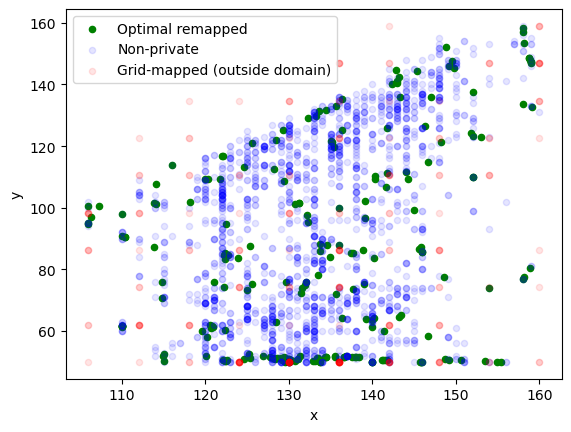

In [40]:
fig, ax = plt.subplots()
optimal_remapped_data.plot(kind='scatter', x='x', y='y', color='green', ax=ax, alpha=1)
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)
ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])

In [41]:
plain_df_2d_renamed.min()

x    106.0
y     50.0
dtype: float64

In [42]:
def mechanism_design(plain_df, perturbed_df, grid_size=10, columns=['x', 'y'], epsilon=0.1):
    perturbed_df_with_grid_remapping = helpers.truncate_n_dimensional_laplace_noise(perturbed_df.drop(columns=['r']).values, plain_df.values, grid_size=grid_size, columns=columns, include_indicator=True)
    #perturbed_df_find_grid_remappings = perturbed_df_with_grid_remapping[perturbed_df_with_grid_remapping['is_remapped']]
    perturbed_df_find_grid_remappings_with_r = pd.concat([perturbed_df['r'], perturbed_df_with_grid_remapping], axis=1)
    perturbed_df_optimal_remapping = optimal_remapping(perturbed_df_find_grid_remappings_with_r, plain_df, epsilon=epsilon)
    return perturbed_df_optimal_remapping

In [43]:
perturbed_df_optimal_remapping = mechanism_design(plain_df_2d_renamed, perturbed_data_with_r)

<AxesSubplot:xlabel='x', ylabel='y'>

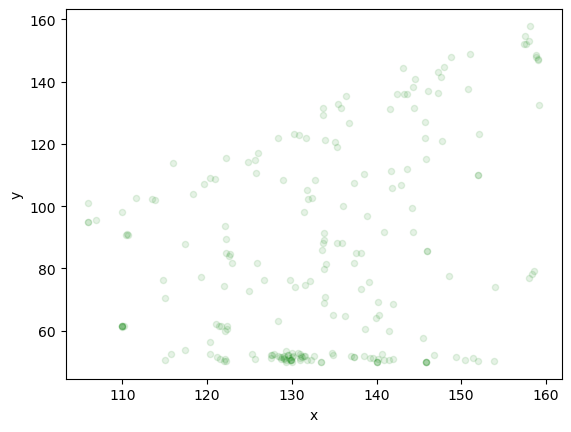

In [44]:
perturbed_df_optimal_remapping.plot(kind='scatter', x='x', y='y', color='green', alpha=0.1)

## 3D Variant

In [45]:
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d = perturbed_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d.head()

,baseline value,histogram_min,accelerations
0,143.085375,62.000007,-1.574761
1,156.148066,67.998066,6.570822
2,151.820138,68.002038,-0.495178
3,161.102637,52.999833,6.539972
4,148.282493,53.002594,9.905883


In [46]:
from Helpers import threed_laplace

epsilon = 0.5

In [47]:
def generate_3D_noise_for_dataset(plain_df:pd.DataFrame, epsilon):
    Z = []
    R = []
    X = np.array(plain_df)
    for x in X: 
        noise = generate_3D_noise(epsilon)
        z = x + noise[:3]
        Z.append(z)
        R.append(noise[3])
    return pd.concat((pd.DataFrame(Z, columns=plain_df.columns), pd.DataFrame(R, columns=['r'])), axis=1)
def generate_3D_noise(epsilon): 
    polar_angle, azimuth, _ = threed_laplace.generate_unit_sphere() # theta, psi
    r = threed_laplace.generate_r(epsilon)
    # theta = 2 * np.pi * u[0]
    #theta = np.random.rand() * np.pi
    #phi = np.arccos(2 * u[1] - 1)
    #phi = np.random.rand() * np.pi*2 # 
    # https://mathworld.wolfram.com/SphericalCoordinates.html formula 4/5/6
    x = r * np.sin(polar_angle) * np.sin(azimuth)
    y = r * np.sin(polar_angle) * np.cos(azimuth)
    z = r * np.cos(polar_angle)
    return x, y, z, r

In [48]:
perturbed_df_3d = generate_3D_noise_for_dataset(plain_df_3d, epsilon)
#perturbed_df_3d = pd.DataFrame(perturbed_df_3d, columns=['baseline value', 'histogram_min', 'accelerations'])
perturbed_df_3d.head()

,baseline value,histogram_min,accelerations,r
0,115.287028,63.214213,1.551334,5.108136
1,135.546731,70.587026,8.520711,6.301494
2,130.549352,69.508949,4.879697,4.071272
3,136.627091,49.781322,5.678373,5.549047
4,138.940840,45.043183,5.898289,10.727987


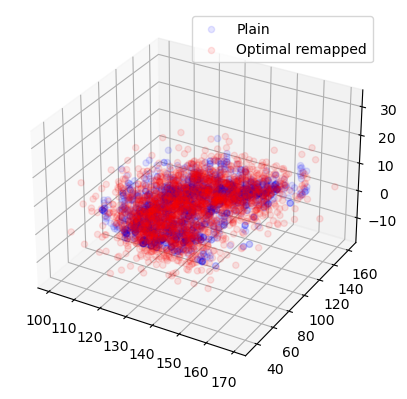

In [49]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)
ax.scatter3D(perturbed_df_3d['baseline value'], perturbed_df_3d['histogram_min'], perturbed_df_3d['accelerations'], color='red', alpha=0.1)
#plain_df_3d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])

In [50]:
perturbed_df_3d_grid_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_df_3d.drop(columns=['r']).values, plain_df_3d.values, grid_size=10, columns=['baseline value', 'histogram_min', 'accelerations'], include_indicator=True)
perturbed_df_3d_outside_domain = perturbed_df_3d[perturbed_df_3d_grid_remapped['is_remapped']]
print(perturbed_df_3d_outside_domain.shape, perturbed_df_3d_grid_remapped.shape)

(1002, 4) (2126, 4)


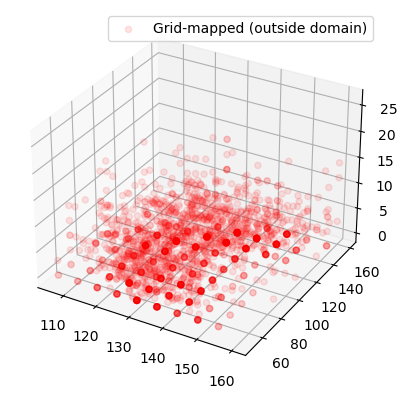

In [51]:
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter3D(perturbed_df_3d_outside_domain['baseline value'], perturbed_df_3d_outside_domain['histogram_min'], perturbed_df_3d_outside_domain['accelerations'], color='blue', alpha=0.1)
#ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='green', alpha=0.1)
ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
ax.legend(['Grid-mapped (outside domain)']) 
#ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
#perturbed_df_3d_grid_remapped.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)

In [52]:
perturbed_df_remapped = mechanism_design(plain_df_3d, perturbed_df_3d, epsilon=0.5, columns=plain_df_3d.columns)

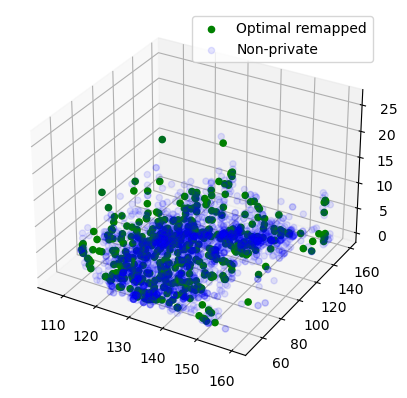

In [53]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(perturbed_df_remapped['baseline value'], perturbed_df_remapped['histogram_min'], perturbed_df_remapped['accelerations'], color='green', alpha=1)
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)

ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])


## Trying mechanism design

In [54]:
from Helpers import helpers 

plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")
plain_df = plain_df.drop(columns=['class'])
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]

In [55]:
plain_df_3d.head()

,baseline value,histogram_min,accelerations
0,120.0,62.0,0.0
1,132.0,68.0,4.0
2,133.0,68.0,2.0
3,134.0,53.0,2.0
4,132.0,53.0,4.0


Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
      baseline value  histogram_min  accelerations  is_remapped
0         122.200914      62.706150       1.534152        False
1         142.000000      62.111111       0.000000         True
2         131.713810      68.832738       2.769598        False
3         133.675890      50.076624       1.857848        False
4         137.533708      52.769349       6.563879        False
...              ...            ...            ...          ...
2121      136.000000     134.777778       0.000000         True
2122      136.000000      98.444444       0.000000         True
2123      142.000000      98.444444       0.000000         True
2124      142.000000     110.555556       0.000000         True
2125      137.951763     117.018409       0.420449        False

[2126 rows x 4 columns]
All

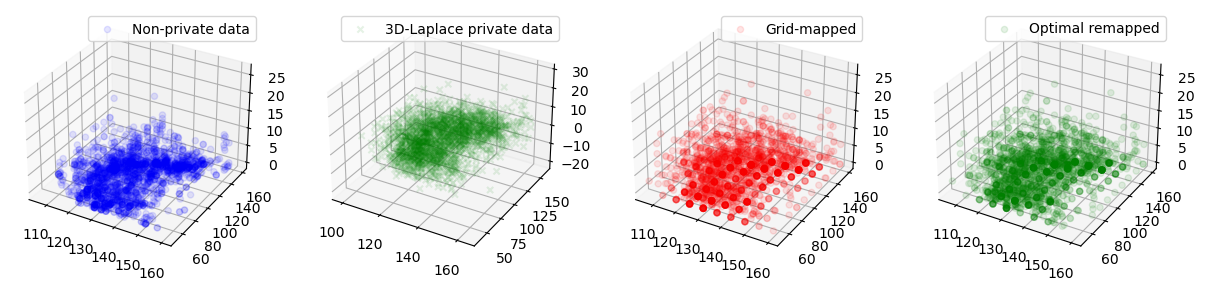

(2126, 4) (2126, 3)


In [56]:
from Helpers.ldp_mechanism import ldp_mechanism

mechanism = ldp_mechanism(epsilon=0.5)
private_dataset_3d = mechanism.randomise(non_private_dataset=plain_df_3d, epsilon=0.5, plot_validation=True)
print(private_dataset_3d.shape, plain_df_3d.shape)

In [57]:
private_dataset_3d.head()

,r,baseline value,histogram_min,accelerations
0,2.774219,122.200914,62.706150,1.534152
1,11.722970,139.340813,64.583526,0.679561
2,1.714649,131.713810,68.832738,2.769598
3,2.944721,133.675890,50.076624,1.857848
4,6.103163,137.533708,52.769349,6.563879


In [58]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
      baseline value  histogram_min  is_remapped
0         121.369660      60.216162        False
1         127.532331      68.289758        False
2         129.977239      66.545909        False
3         129.516285      52.258992        False
4         132.759893      52.503230        False
...              ...            ...          ...
2121      140.831778     135.192244        False
2122      137.511000     106.449879        False
2123      142.495480      99.565195        False
2124      137.929958     102.193174        False
2125      140.078852     113.536302        False

[2126 rows x 3 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (99, 3)
Shapes (2126, 3) (2126, 3) (2126, 3) (2126, 4)


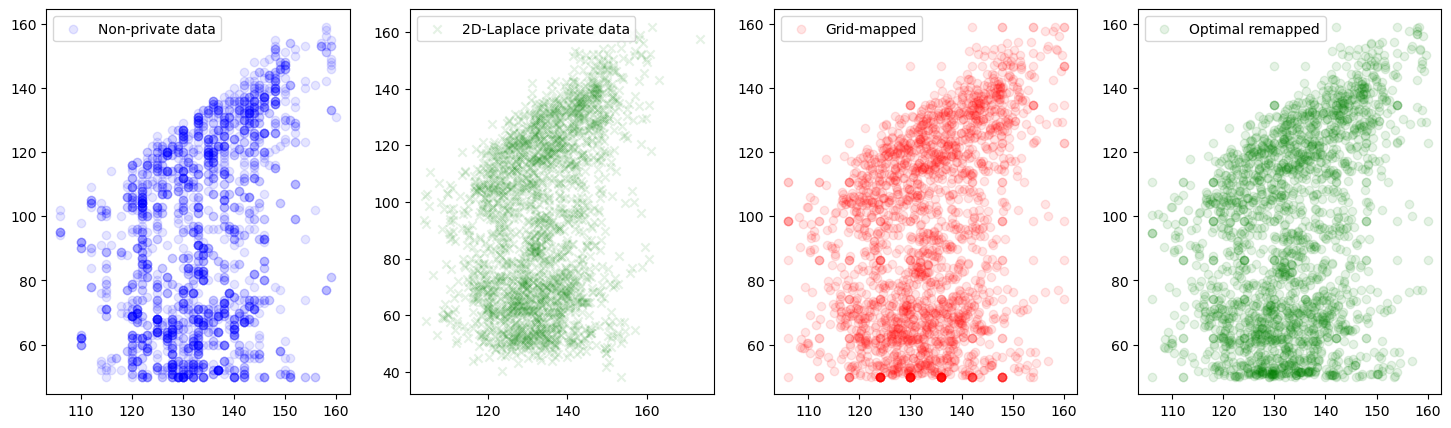

,r,baseline value,histogram_min
0,2.249010,121.369660,60.216162
1,4.477056,127.532331,68.289758
2,3.354320,129.977239,66.545909
3,4.544534,129.516285,52.258992
4,0.907864,132.759893,52.503230


In [59]:
private_dataset_2d = mechanism.randomise(plain_df_2d, plot_validation=True, epsilon=0.5)
private_dataset_2d.head()

## Trying with lower privacy budget (0.1)

Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
      baseline value  histogram_min  is_remapped
0         132.489288      56.144099        False
1         131.542970      90.605560        False
2         128.059549      89.334261        False
3         112.775615      79.014104        False
4         160.000000      50.000000         True
...              ...            ...          ...
2121      136.000000     146.888889        False
2122      148.000000     122.666667        False
2123      148.000000      98.444444        False
2124      109.187243      91.539276        False
2125      140.954872     139.377728        False

[2126 rows x 3 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (511, 3)
Shapes (2126, 3) (2126, 3) (2126, 3) (2126, 4)


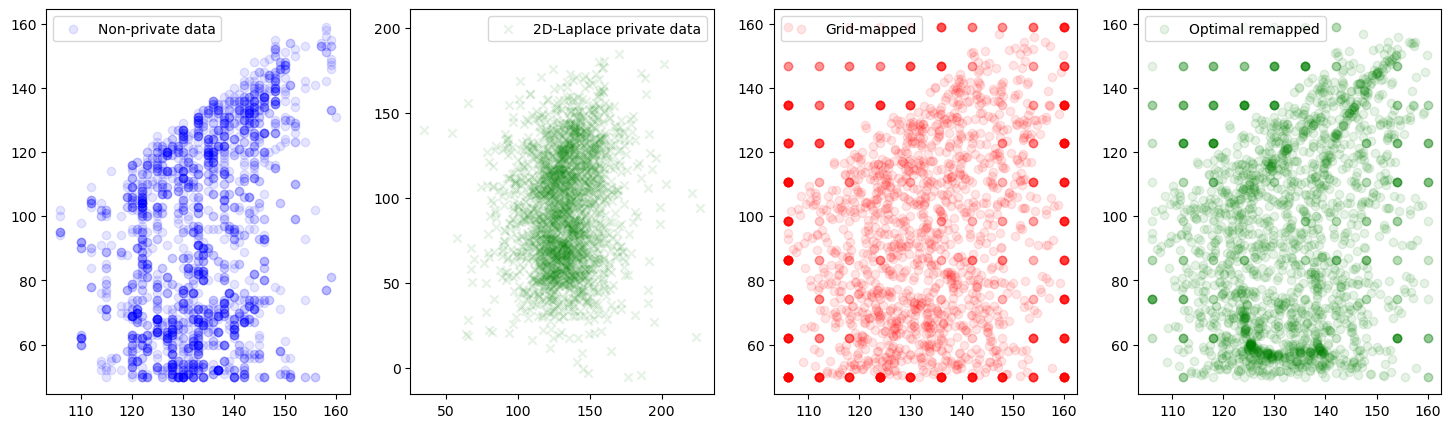

In [60]:
mechanism_more_private = ldp_mechanism(epsilon=0.1)
private_dataset_2d_more_private = mechanism_more_private.randomise(plain_df_2d, plot_validation=True, epsilon=0.1)

Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
      baseline value  histogram_min  accelerations  is_remapped
0              112.0      62.111111      26.000000         True
1              130.0      62.111111       0.000000         True
2              124.0      62.111111       0.000000         True
3              106.0      50.000000      26.000000         True
4              124.0      50.000000      23.111111        False
...              ...            ...            ...          ...
2121           142.0     134.777778       0.000000         True
2122           160.0     110.555556       0.000000         True
2123           142.0      86.333333      17.333333        False
2124           148.0      86.333333       0.000000         True
2125           124.0     122.666667      20.222222        False

[2126 rows x 4 columns]
All

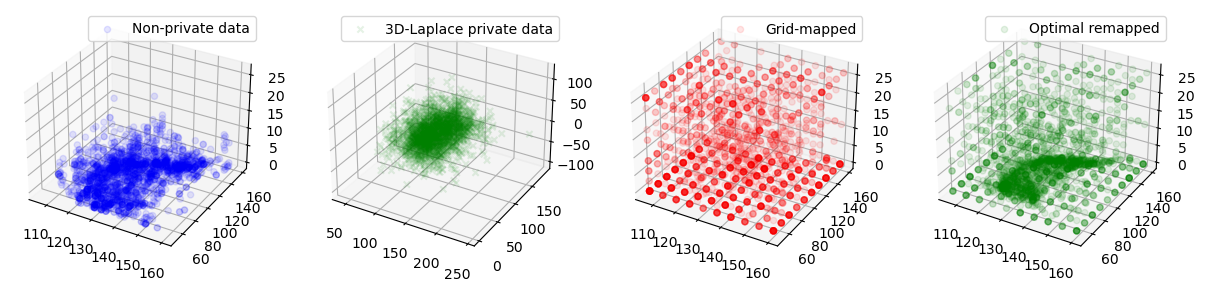

In [61]:
private_dataset_3d_more_private = mechanism_more_private.randomise(plain_df_3d, plot_validation=True, epsilon=0.1)

In [62]:
private_dataset_3d_more_private.shape

(2126, 4)

## Considering seeds dataset

In [63]:
from Helpers import helpers
plain_seed_df, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq1.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df_without_class = plain_seed_df.drop(columns=['class'])
plain_seed_df_without_class.head()

,area,perimeter
0,15.26,14.84
1,14.88,14.57
2,14.29,14.09
3,13.84,13.94
4,16.14,14.99


Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  is_remapped
0    21.180000  17.250000         True
1    12.943333  17.250000         True
2    18.826667  12.410000         True
3    12.943333  12.410000         True
4    14.838624  14.542472        False
..         ...        ...          ...
205  11.766667  17.250000        False
206  13.455999  13.698011        False
207  14.120000  12.947778        False
208  14.120000  17.250000         True
209  10.590000  17.250000         True

[210 rows x 3 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (110, 3)
Shapes (210, 3) (210, 3) (210, 3) (210, 4)


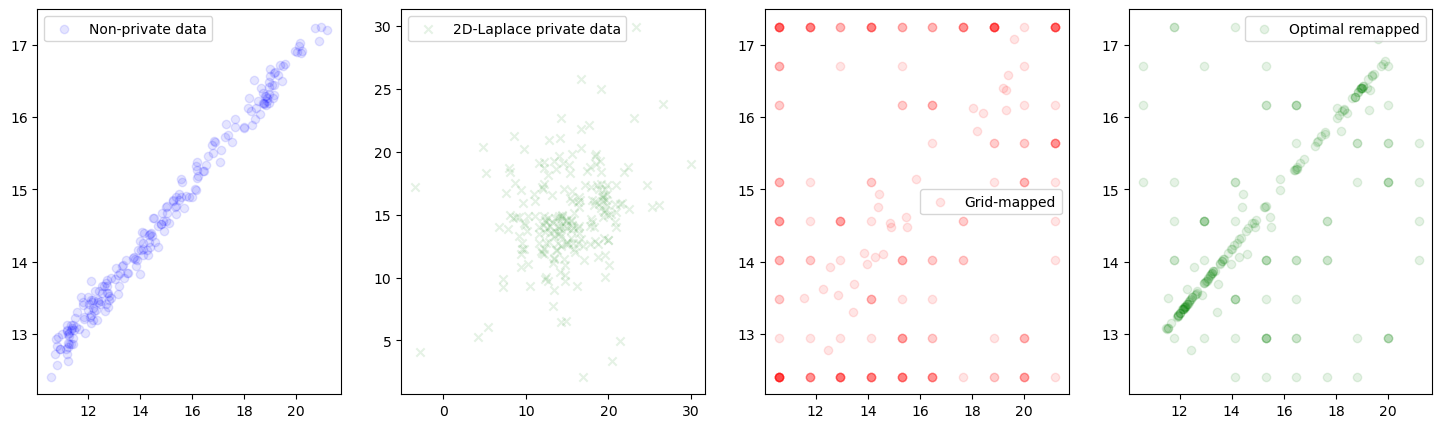

(210, 3) (210, 2)


In [64]:
from Helpers.ldp_mechanism import ldp_mechanism

mechanism = ldp_mechanism(epsilon=0.5)
private_seed_dataset = mechanism.randomise(non_private_dataset=plain_seed_df_without_class, epsilon=0.5, plot_validation=True)
print(private_seed_dataset.shape, plain_seed_df_without_class.shape)

Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  is_remapped
0    15.296667  12.410000         True
1    10.590000  17.250000         True
2    21.180000  17.250000         True
3    21.180000  12.410000         True
4    21.180000  17.250000         True
..         ...        ...          ...
205  10.590000  12.410000         True
206  11.766667  12.410000         True
207  17.650000  12.410000         True
208  10.590000  12.947778         True
209  11.766667  17.250000         True

[210 rows x 3 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (198, 3)


Shapes (210, 3) (210, 3) (210, 3) (210, 4)


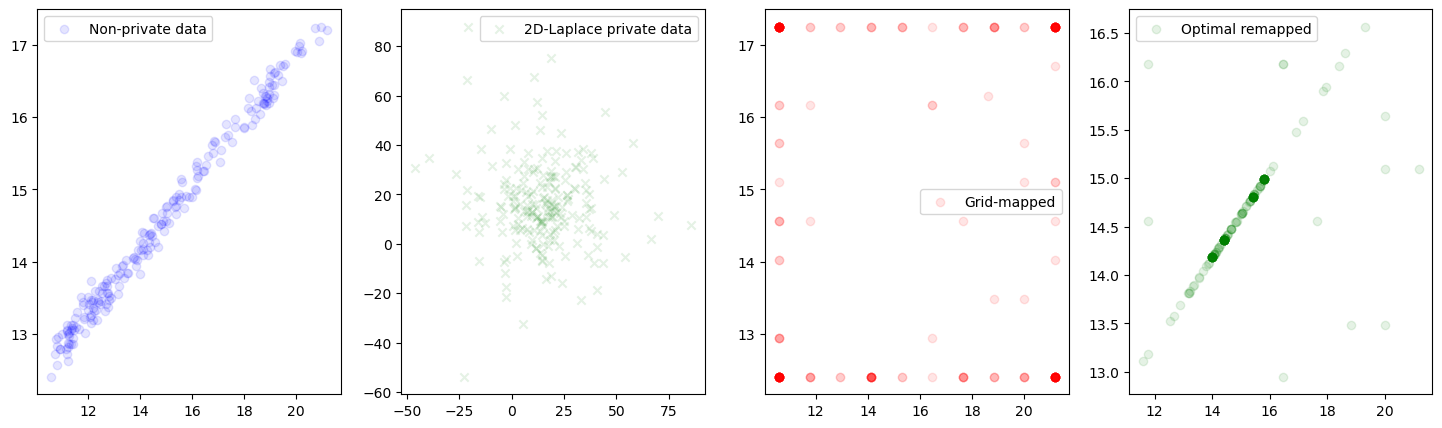

In [65]:
mechanism = ldp_mechanism(epsilon=0.1)
private_seed_dataset = mechanism.randomise(non_private_dataset=plain_seed_df_without_class, epsilon=0.1, plot_validation=True)

In [66]:
mechanism = ldp_mechanism(epsilon=0.5)
plain_seed_df_3d, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq2.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df_3d_without_class  = plain_seed_df_3d.drop(columns=['class'])
plain_seed_df_3d_without_class.head()

,area,perimeter,length of kernel
0,15.26,14.84,5.763
1,14.88,14.57,5.554
2,14.29,14.09,5.291
3,13.84,13.94,5.324
4,16.14,14.99,5.658


Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  length of kernel  is_remapped
0    10.590000  17.250000          5.491000         True
1    16.473333  14.561111          6.675000         True
2    14.120000  14.023333          6.675000         True
3    17.650000  12.410000          6.675000         True
4    21.180000  17.250000          6.477667         True
..         ...        ...               ...          ...
205  10.590000  17.250000          4.899000         True
206  10.590000  12.410000          6.675000         True
207  10.590000  12.410000          4.899000         True
208  14.120000  16.174444          5.688333        False
209  15.296667  13.485556          5.293667        False

[210 rows x 4 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.

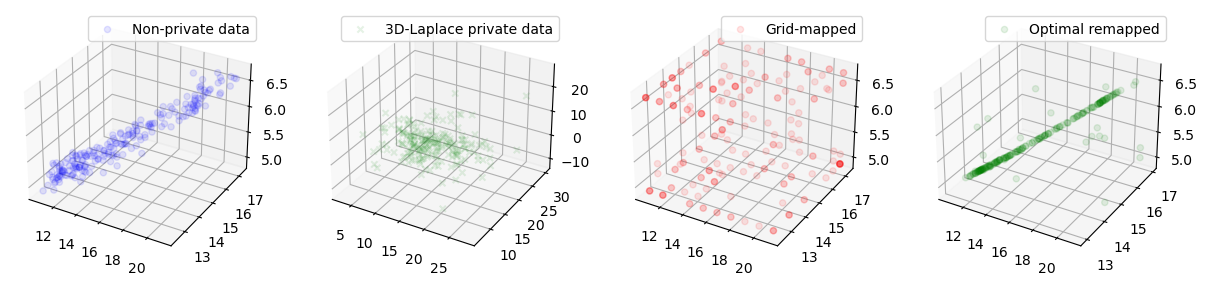

In [67]:
private_seed_dataset_3d = mechanism.randomise(non_private_dataset=plain_seed_df_3d_without_class, epsilon=0.5, plot_validation=True)

In [68]:
private_seed_dataset_3d

,r,area,perimeter,length of kernel
0,8.560040,13.243425,13.849027,5.401534
1,2.597839,15.309261,14.776536,5.674925
2,2.405031,14.130339,14.231539,5.499266
3,6.217534,15.619464,14.901529,5.728683
4,6.031916,19.185917,16.482755,6.284368
...,...,...,...,...
205,14.850196,13.271830,13.860688,5.403233
206,7.049637,12.208703,13.385141,5.263171
207,6.223860,12.050191,13.304821,5.236782
208,3.353614,14.120000,16.174444,5.688333
